# Circumplex Model examination

In [24]:
%pip install matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict

Note: you may need to restart the kernel to use updated packages.


In [38]:
vocabulary_plutchik = [
    'Interest',
    'Serenity',
    'Acceptance',
    'Anticipation',
    'Optimism',
    'Joy',
    'Love',
    'Trust',
    'Aggressiveness',
    'Vigilance',
    'Ecstasy',
    'Admiration',
    'Submission',
    'Annoyance',
    'Anger',
    'Rage',
    'Terror',
    'Fear',
    'Apprehension',
    'Contempt',
    'Loathing',
    'Grief',
    'Amazement',
    'Awe',
    'Disgust',
    'Remorse',
    'Sadness',
    'Disappointment',
    'Surprise',
    'Boredom',
    'Pensiveness',
    'Distraction'
]

vocabulary_plutchik_senses = {
    'Interest' : '05682950',
    'Serenity' : '04904352',
    'Acceptance' : '06193727',
    'Anticipation' : '14486122',
    'Optimism' : '07541558',
    'Joy' : '01813884',
    'Love' : '01775164',
    'Trust' : '00688377',
    'Aggressiveness' : '01244846',
    'Vigilance' : '04664778',
    'Ecstasy' : '13986372',
    'Admiration' : '01218593',
    'Submission' : '01166926',
    'Annoyance' : '05830059',
    'Anger' : '14036539',
    'Rage' : '07516997',
    'Terror' : '07520612',
    'Fear' : '07519253',
    'Apprehension' : '07521674',
    'Contempt' : '07502980',
    'Loathing' : '07503430',
    'Grief' : '07535010',
    'Amazement' : '07509572',
    'Awe' : '07510184',
    'Disgust' : '01808374',
    'Remorse' : '07536074',
    'Sadness' : '07532440',
    'Disappointment' : '07540602',
    'Surprise' : '00725274',
    'Boredom' : '07539790',
    'Pensiveness' : '07533607',
    'Distraction' : '05684440'
}


vocabulary_basic = [
    'Happiness',
    'Surprise',
    'Anger',
    'Disgust',
    'Fear',
    'Sadness',
    'Neutral'
]

vocabulary_basic_senses = {
    'Happiness' : '13987423',
    'Surprise': '00725274',
    'Anger': '14036539',
    'Disgust': '01808374',
    'Fear': '07519253',
    'Sadness': '07532440',
    'Neutral': '10355142'
}

Happiness 13987423 1.0 state of well-being characterized by emotions ranging from contentment to intense joy

Surprise 00725274 0.125 cause to be surprised; "The news really surprised me"

Anger 14036539 -1.0 the state of being angry

Disgust 01808374 -0.5 cause aversion in; offend the moral sense of; "The pornographic pictures sickened us"

Fear 07519253 -0.875 an emotion experienced in anticipation of some specific pain or danger (usually accompanied by a desire to flee or fight)

Sadness 07532440 -0.75 emotions experienced when not in a state of well-being

Neutral 10355142 -0.125 one who does not side with any party in a war or dispute



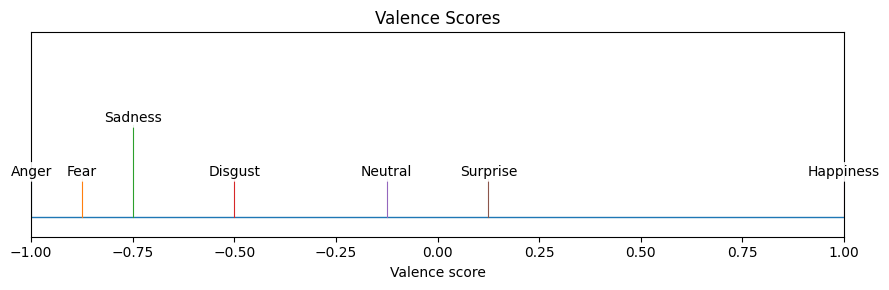

In [43]:
def load_sentiwordnet_scores(
    filepath="/home/kai/Repositories/Ontology-For-Affective-Computing/sources/SentiWordNet_3.0.0.txt"
):
    """
    Load SentiWordNet file and compute net scores for each synset term.

    """
    sentiwordnet = {}

    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            # skip comments and empty lines
            if not line.strip() or line.startswith("#"):
                continue

            parts = line.split("\t")
            if len(parts) < 5:
                continue  # malformed line

            pos = str(parts[0])
            id = str(parts[1])
            gloss = str(parts[5])
            pos_score = float(parts[2])
            neg_score = float(parts[3])
            net_score = pos_score - neg_score

            terms = parts[4].split()
            sentiwordnet[id] = {}
            sentiwordnet[id]['POS'] = pos
            sentiwordnet[id]['terms'] = terms
            sentiwordnet[id]['PosScore'] = pos_score
            sentiwordnet[id]['NegScore'] = neg_score
            sentiwordnet[id]['NetScore'] = net_score
            sentiwordnet[id]['Glossary'] = gloss
            

    return sentiwordnet

def get_scores_all(word, scores_dict):
    """
    Retrieve all senses and scores for a given lemma (without #).
    Example: get_scores_all("able", scores) -> {"able#1": 0.125, "able#2": ...}
    """
    return {k: v for k, v in scores_dict.items() if k.startswith(word + "#")}

def get_scores_exact(word, scores_dict):
    """
    Retrieve all senses and scores for a given lemma (without #).
    Example: get_scores_all("able", scores) -> {"able#1": 0.125, "able#2": ...}
    """
    return {k: v for k, v in scores_dict.items() if k == word}

def match_sentinet(words):
    """
    Finds the corresponding words in Sentinet
    """
    senti_scores = load_sentiwordnet_scores()
    if isinstance(words, list):
        words_to_match = {}
        for word in words:
            words_to_match[word] = (get_scores_all(word.lower(), senti_scores))
        return words_to_match
    
    elif isinstance(words, str):
        word_to_match = get_scores_all(words.lower(), senti_scores)
        return word_to_match

    elif isinstance(words, dict):
        words_to_match = {}
        for word, sense in words.items():
            words_to_match[word] = get_scores_exact(sense, senti_scores)
        return words_to_match
            
def plot_labels(values_dict, title="Valence Scores",
                         xlim=(-1, 1), start_y=0.2, dy=0.28,
                         figsize=(9, 3), max_iter=200, rotation=0):
    """
    Timeline-style plot: y=0 baseline, labels above with stems (lines).
    Overlap is resolved using only the TEXT bounding boxes (not arrows),
    which avoids the infinite loop.
    """
    # sort by x so close points are handled consecutively
    items = sorted(values_dict.items(), key=lambda kv: float(kv[1]))

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(*xlim)
    ax.axhline(0, lw=1)
    ax.set_yticks([])
    ax.set_xlabel("Valence score")
    ax.set_title(title)

    placed_text_bboxes = []   # window (pixel) bboxes of placed text
    placed_positions = []     # (x, y) for drawing stems later

    for label, x in items:
        x = float(x)
        y = start_y

        # place, measure, bump until no overlap with previous text boxes
        txt_artist = None
        for _ in range(max_iter):
            # draw text only (no arrow) so bbox is just the label
            txt_artist = ax.text(
                x, y, label, ha="center", va="bottom", rotation=rotation,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.9)
            )
            fig.canvas.draw()  # needed so the renderer knows the bbox size
            renderer = fig.canvas.get_renderer()
            bbox = txt_artist.get_window_extent(renderer)

            # if overlaps any previous text bbox, bump up and try again
            if any(bbox.overlaps(prev) for prev in placed_text_bboxes):
                txt_artist.remove()
                y += dy
                continue

            # no overlap: keep it and store bbox/pos
            placed_text_bboxes.append(bbox)
            placed_positions.append((x, y))
            break
        else:
            # safety: if we exceeded max_iter, keep the last placement
            placed_text_bboxes.append(bbox)
            placed_positions.append((x, y))

    # draw stems (after text placement so stems don't affect bbox logic)
    for x, y in placed_positions:
        ax.plot([x, x], [0, y], lw=0.8)

    # make sure everything fits vertically
    top_y = max((y for _, y in placed_positions), default=start_y)
    ax.set_ylim(-0.1, top_y + dy + 0.2)

    plt.tight_layout()
    plt.show()



plutchik_list = match_sentinet(vocabulary_plutchik)
basic_list = match_sentinet(vocabulary_basic)
basic_list_sense = match_sentinet(vocabulary_basic_senses)
scores = {}
for k, v in basic_list_sense.items():
    for sub_k, sub_v in v.items():
        scores[k] = sub_v['NetScore']
        print(k, sub_k, sub_v['NetScore'], sub_v['Glossary'])
plot_labels(scores)

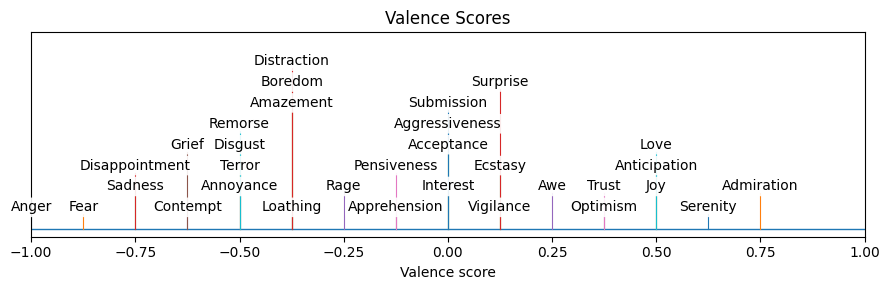

In [44]:
plutchik_list_sense = match_sentinet(vocabulary_plutchik_senses)
scores = {}
for k, v in plutchik_list_sense.items():
    for sub_k, sub_v in v.items():
        scores[k] = sub_v['NetScore']
plot_labels(scores)